# Import Libraries

In [35]:
# import the necessary packages
from imutils import perspective
from imutils import contours
import numpy as np
from matplotlib import pyplot as plt
import imutils
import cv2

# Function Definition

In [36]:
def showImgcv2(img):
    try:

        cv2.imshow("Image", cv2.resize(img,(960,600))) 
        if cv2.waitKey(0) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
    except Exception as e:
        print(e)

In [37]:
def showImgplt(img):
    plt.figure(figsize = (15,15))
    plt.imshow(img) 

In [38]:
from dataclasses import dataclass

#Point contains xy coordinates of a point
@dataclass
class Point:
    name: str
    x: float
    y: float

# #Box contains xyxy coordinates of bounding box
# @dataclass
# class Box:
#     class_id: int
#     top_left: Point
#     bottom_right: Point
#     box_center: Point = None

In [39]:
from math import sqrt

def get_distance(point1 : Point, point2: Point):
    return sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2)

def make_vector(point_begin : Point, point_end: Point):
    vector_x = point_end.x - point_begin.x
    vector_y = point_end.y - point_begin.y
    vector = np.array([vector_x,vector_y])
    return vector

# Camera Acquisition

## Iniatialize Camera

In [40]:
# import ids_peak.ids_peak as ids_peak

# ids_peak.Library.Initialize()
# device_manager = ids_peak.DeviceManager.Instance()
# device_manager.Update()
# device_descriptors = device_manager.Devices()

# print("Found Devices: " + str(len(device_descriptors)))
# for device_descriptor in device_descriptors:
#     print(device_descriptor.DisplayName())

## Open Camera


In [41]:
# device = device_descriptors[0].OpenDevice(ids_peak.DeviceAccessType_Control)
# print("Opened Device: " + device.DisplayName())
# remote_device_nodemap = device.RemoteDevice().NodeMaps()[0]

In [42]:
# remote_device_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
# remote_device_nodemap.FindNode("TriggerSource").SetCurrentEntry("Software")
# remote_device_nodemap.FindNode("TriggerMode").SetCurrentEntry("On")

## Start Acquisition

In [43]:
# datastream = device.DataStreams()[0].OpenDataStream()
# payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
# for i in range(datastream.NumBuffersAnnouncedMinRequired()):
#     buffer = datastream.AllocAndAnnounceBuffer(payload_size)
#     datastream.QueueBuffer(buffer)
    
# datastream.StartAcquisition()
# remote_device_nodemap.FindNode("AcquisitionStart").Execute()
# remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

## Exposure Control

Basically brightness control

In [44]:
#remote_device_nodemap.FindNode("ExposureTime").SetValue(5000) # in microseconds

## Acquire Single Frame

In [45]:
# # trigger image
# remote_device_nodemap.FindNode("TriggerSoftware").Execute()
# buffer = datastream.WaitForFinishedBuffer(1000)

# # convert to RGB
# import ids_peak_ipl.ids_peak_ipl as ids_ipl
# import ids_peak.ids_peak_ipl_extension as ids_ipl_extension
# raw_image = ids_ipl_extension.BufferToImage(buffer)
# # for Peak version 2.0.1 and lower, use this function instead of the previous line:
# #raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
# color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_RGB8)
# datastream.QueueBuffer(buffer)

# import numpy as np
# picture = color_image.get_numpy_3D()

# # display the image
# from matplotlib import pyplot as plt
# plt.figure(figsize = (15,15))
# plt.imshow(picture)

In [46]:

# ids_peak.Library.Close()

In [47]:
# import cv2
# #gray_image = cv2.cvtColor(picture, cv2.COLOR_RGB2GRAY)
# cv2.imshow("Neubauer Chamber", picture)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Camera Single Function

In [48]:
# import the necessary packages
from imutils import perspective
from imutils import contours
import numpy as np
from matplotlib import pyplot as plt
import imutils
import cv2
import ids_peak.ids_peak as ids_peak
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import ids_peak.ids_peak_ipl_extension as ids_ipl_extension

def get_image():
    try:
        # Initialize the IDS peak API
        ids_peak.Library.Initialize()

        # Create a device manager instance
        device_manager = ids_peak.DeviceManager.Instance()

        # Update the device list
        device_manager.Update()

        device_descriptor = device_manager.Devices()

        # Get the first available camera device
        camera = device_descriptor[0].OpenDevice(ids_peak.DeviceAccessType_Control)
    
        remote_device_nodemap = camera.RemoteDevice().NodeMaps()[0]
        
        #Set to single frame mode
        #remote_device_nodemap.FindNode("AcquisitionMode").SetCurrentEntry("SingleFrame")
        
        remote_device_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
        remote_device_nodemap.FindNode("TriggerSource").SetCurrentEntry("Software")
        remote_device_nodemap.FindNode("TriggerMode").SetCurrentEntry("On")
        
        
        
        #---------------------------------------------------#
        # Set to continuous acquisition mode (trigger mode can be set as needed)
        datastream = camera.DataStreams()[0].OpenDataStream()

        payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
        for i in range(datastream.NumBuffersAnnouncedMinRequired()):
            buffer = datastream.AllocAndAnnounceBuffer(payload_size)
            datastream.QueueBuffer(buffer)

        # print(range(datastream.NumBuffersAnnouncedMinRequired()))
        #---------------------------------------------------#

        datastream.StartAcquisition()
        remote_device_nodemap.FindNode("AcquisitionStart").Execute()
        remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()
        remote_device_nodemap.FindNode("ExposureTime").SetValue(5000) # in microseconds
        # Retrieve the stream and start it


        remote_device_nodemap.FindNode("TriggerSoftware").Execute()

        # Get a single image
        buffer = datastream.WaitForFinishedBuffer(1000)  # Timeout of 5000ms (5 seconds)
        image_data = ids_ipl_extension.BufferToImage(buffer)
        mono_image = image_data.ConvertTo(ids_ipl.PixelFormatName_RGB8)
        image_np = mono_image.get_numpy_3D()
        # Display the captured image using OpenCV
        datastream.QueueBuffer(buffer) # Return buffer to the queue
        
        #Copy image to keep data, otherwise if buffer closes then no more data available
        image = image_np.copy()
        
        #====DEBUG====#
        #print(image.shape)
        #showImgcv2(image_np)
        
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:

        # Release the resources
        
        ids_peak.Library.Close()
    if image is not None:    
        return image
           


new_image = get_image()
showImgcv2(new_image)


# Corner Detection


Using OpenCV to perform edge detection and find corner coordinates of Neubauer chamber

In [64]:
# load the image, convert it to grayscale, and blur it slightly
#image = cv2.imread("./Microscope/Neubauer4.png")
def get_corner(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(img, (7, 7), 0)

    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # find contours in the edge map
    cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    #orig = img.copy()
    # loop over the contours individually
    box = None
    for c in cnts:
        # This is to ignore that small hair countour which is not big enough
        if cv2.contourArea(c) < 20000: #High res, 2000 filters everything, low res 10000
            continue

        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order (CLOCKWISE), then draw the outline of the rotated 
        # boundingbox
        box = perspective.order_points(box)
        # draw the contours on the image
        
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 5)
        #print(box)
        
        # loop over the original points
        color_list = [(0,0,255),(255,0,0),(0,0,0),(255,0,255)]
        for num, (xA, yA) in enumerate(list(box)):
            # draw circles corresponding to the current points and
            cv2.circle(img, (int(xA), int(yA)), 9, color_list[num], -1)
            cv2.putText(img, "({},{})".format(xA, yA), (int(xA - 50), int(yA - 10) - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 1.8,  color_list[num], 5)

            # show the output image, resize it as per your requirements
            #cv2.imshow("Image", cv2.resize(img,(960,600))) 

        cv2.waitKey(0)

        if cv2.waitKey(0) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
    #print(box)
    if box is not None:
        return box

In [50]:
box = get_corner(new_image)


[[ 446.  581.]
 [ 960.  591.]
 [ 949. 1105.]
 [ 436. 1094.]]


# Extract center of picture (center of screen)

In [70]:
def get_center(img):
    height, width, _ = img.shape

    center = Point("center",width//2, height//2)

    #print(center)
    color_center = (0,153,0)

    cv2.circle(img, (center.x, center.y), 9, color_center, -1)
    cv2.putText(img, "({},{})".format(center.x, center.y), (int(center.x + 25), int(center.y + 25)),
                cv2.FONT_HERSHEY_SIMPLEX, 1.8, color_center, 5)

    #showImgcv2(img)
    #showImgplt(orig)
    return center


In [68]:
get_center(new_image)

Point(name='center', x=960, y=600)

# Calculate shifting vector

Goal is to move point P towards center C --> Vector PC is required

For example, we want to move bottom right corner of Neubauer chamber on picture towards center

In [53]:
#====DEBUG====#
if box is not None: 
    print(list(box))
    print(box.shape)


[array([446., 581.], dtype=float32), array([960., 591.], dtype=float32), array([ 949., 1105.], dtype=float32), array([ 436., 1094.], dtype=float32)]
(4, 2)


In [54]:
if box is not None:    
    corner_list = ['top left', 'top right', 'bottom right', 'bottom left']
    for num,coord in enumerate(list(box)):
        print(f'{corner_list[num]}: {box[num]}')

top left: [446. 581.]
top right: [960. 591.]
bottom right: [ 949. 1105.]
bottom left: [ 436. 1094.]


## Function Definition for Reusability

In [55]:
def get_corner_coordinates(box):
    if box is not None:     
        corner_coordinates = []
        corner_list = ['top left', 'top right', 'bottom right', 'bottom left']
        for num,coord in enumerate(list(box)):
            corner_coordinates.append(Point(corner_list[num],int(coord[0]),int(coord[1])))
        return corner_coordinates
    return None

print(get_corner_coordinates(box))

[Point(name='top left', x=446, y=581), Point(name='top right', x=960, y=591), Point(name='bottom right', x=949, y=1105), Point(name='bottom left', x=436, y=1094)]


Generate PC vector

In [56]:
if box is not None: 
    corner_coordinates = get_corner_coordinates(box)
    point_P = corner_coordinates[2] #Assuming we need bottom right
    point_C = get_center(new_image)
    print(point_P)
    print(point_C)

    vector_PC = make_vector(point_P,point_C) #Unit: pixel

    print(vector_PC)


Point(name='bottom right', x=949, y=1105)
Point(name='center', x=960, y=600)
[  11 -505]


# Convert to motor movement

Based on coordinate system of stage, camera and opencv2, the direction of the image being moved is opposite direction in X of stage (multiply by -1), same in Y

In [57]:
PPMM = 170.65 #1920x1200 with sensor size of 11.251mm x 7.032 so PPM can be acquire either 
              #via Neubauer chamber or simply 1920 / 11.251 = 170.65
STEP_PER_MM = 533.33 #Step/mm for 1/4 microstepping

In [58]:
  
try:
    vector_motorDir = np.array([-vector_PC[0],vector_PC[1]])
    vector_PC_inSteps = np.array(vector_motorDir*STEP_PER_MM/PPMM,dtype='int')

    print(vector_PC_inSteps)
except Exception as e:
    print(f"Error: {e}")


[  -34 -1578]


In [59]:
def wholeProcess(i = 2):
    new_image = get_image()
    box = get_corner(new_image)
    corner = get_corner_coordinates(box)
    
    if corner is not None:

        point_P = corner[i] #Assuming we need bottom right
        point_C = get_center(new_image)
        
        #print(point_P)
        #print(point_C)

        vector_PC = make_vector(point_P,point_C) #Unit: pixel

        #print(vector_PC)

        vector_motorDir = np.array([-vector_PC[0],vector_PC[1]])
        vector_PC_inSteps = np.array(vector_motorDir*STEP_PER_MM/PPMM,dtype='int')

        #print(vector_PC_inSteps)

        return vector_PC_inSteps
    return None


  

In [60]:
print(wholeProcess())

[[ 446.  581.]
 [ 959.  591.]
 [ 949. 1105.]
 [ 436. 1095.]]
[  -34 -1578]


# Send to Arduino

Initial steps towards bottom right corner is X: 42290 steps, Y: 69340 steps

In [61]:
def scriptBox(i = 2):
    pic = get_image()
    temp_corner = get_corner(pic)
    temp_corner_coordinates = get_corner_coordinates(temp_corner)
    center = get_center(pic)
    showImgcv2(pic)
    delta_e = get_distance(center,temp_corner_coordinates[i]) #corner coordinates depends on which corner of the grid is taken 
                                                            #0 - top left, 1 - top right, 2 - bottom right, 3 - bottom left
    #delta_vector = make_vector(center, temp_corner_coordinates[i])
    print("Distance between center and corner[%s]: %s px" % (i,delta_e))
    #print("Vector of center to corner in px: %s" % delta_vector)

In [72]:
import serial
import time

# Specify the serial port and baud rate to match your Arduino
arduino_port = 'COM7'  # Replace 'COM3' with your actual port, e.g., '/dev/ttyUSB0' for Linux
baud_rate = 9600



# Initialize the serial connection
ser = serial.Serial(arduino_port, baud_rate, timeout=1)
time.sleep(2)  # Allow time for the connection to initialize

# Function to send data to Arduino
def send_data_to_arduino(data):
    # Convert the data to bytes and send
    ser.write(data.encode())

# Send some test data

def send_coord(x,y):
    coord = f"<{x},{y}>"
    ser.write(coord.encode())
    print(f"Sent coordinates: {coord.strip()}")

try:
    while True:  
        dataPacket = ser.readline()
        print(dataPacket)
        user_input = input("Enter a character to send to Arduino (or type 'exit' to quit): ")
        # dataPacket = ser.readline()
        # print(dataPacket)
        if user_input == 'exit':
            break
        elif user_input == 'c':
            send_data_to_arduino('c')
            user_inputX = input("Enter X coordinate: ")
            user_inputY = input("Enter Y coordinate: ")
            send_coord(user_inputX,user_inputY)
        elif user_input == 'v':
            try:
                vectorMove = wholeProcess(2)
                if vectorMove is not None:
                    send_data_to_arduino('c')
                    send_coord(int(vectorMove[0]),int(vectorMove[1]))
                else:
                    print("No input")
            except Exception as e:
                print(e)
        elif user_input == "p":
            try:    
                pic = get_image()
                
                temp_corner = get_corner(pic)
                temp_corner_coordinates = get_corner_coordinates(temp_corner)
                center = get_center(pic)
                showImgcv2(pic)
                delta_e = get_distance(center,temp_corner_coordinates[2]) #corner coordinates depends on which corner of the grid is taken 
                                                                        #0 - top left, 1 - top right, 2 - bottom right, 3 - bottom left
                delta_vector = make_vector(center, temp_corner_coordinates[2])
                print("Distance between center and bottom right corner: %s px" % delta_e)
                print("Vector of center to corner in px: %s" % delta_vector)
            except Exception as e:
                print(e)
        elif user_input == "b":
            try:    
                # 2 -> 3 -> 0 -> 1
                corner_sequence = [2,3,0,1,2]
                for corner in corner_sequence:
                    vectorMove = wholeProcess(corner)
                    if vectorMove is not None:
                        send_data_to_arduino('c')
                        send_coord(int(vectorMove[0]),int(vectorMove[1]))
                    else:
                        print("No input")

                    time.sleep(2)
                    scriptBox(corner)
               
            except Exception as e:
                print(e)
        elif len(user_input) == 1:
            send_data_to_arduino(user_input)
        else:
            print("Please enter valid option.")
        # if ser.in_waiting > 0:
        #     response = ser.readline().decode().strip()
        #     print(f"Arduino response: {response}")
finally:
    ser.close()  # Close the serial connection when done

b''
Sent coordinates: <-6,25>
Distance between center and corner[2]: 0.0 px
Sent coordinates: <-1603,31>
Distance between center and corner[3]: 9.219544457292887 px
Sent coordinates: <34,1584>
Distance between center and corner[0]: 5.385164807134504 px
Sent coordinates: <1590,-37>
Distance between center and corner[1]: 9.848857801796104 px
Sent coordinates: <-34,-1578>
Distance between center and corner[2]: 5.830951894845301 px
b''
Sent coordinates: <12,3>
Distance between center and corner[2]: 1.0 px
Sent coordinates: <-1603,34>
Distance between center and corner[3]: 10.0 px
Sent coordinates: <34,1581>
Distance between center and corner[0]: 5.0990195135927845 px
Sent coordinates: <1590,-40>
Distance between center and corner[1]: 10.295630140987 px
Sent coordinates: <-34,-1578>
Distance between center and corner[2]: 7.810249675906654 px
b''
Sent coordinates: <18,0>
Distance between center and corner[2]: 1.4142135623730951 px
Sent coordinates: <-1606,37>
Distance between center and corn

WASD for moving (WS: +-X, AD: +-Y)

C for manual coordinates input <br>
V for corner detection and correction<br>
P for getting image<br>
G for getting XY steps<br>
H for homing<br>


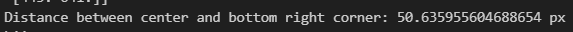